# Tutorial: Spatial Network analysis

**Lesson objectives**

This tutorial focuses on **spatial networks** and learn how to construct a routable **directed** graph for NetworkX and find shortest paths along the given street network. Furthermore, we will learn how these methods can be scaled to analyze spatial accessibility on a regional level and conduct two-step floating catchment area assessment to understand healthcare accessibility.

## Tutorial

In this tutorial we will focus on a network analysis methods that relate to way-finding.
Finding a shortest path from A to B using a specific street network is a very common spatial analytics
problem that has many practical applications.

Python provides easy to use tools for conducting spatial network analysis.
One of the easiest ways to start is to use a library
called [Networkx](https://networkx.github.io/documentation/stable/)
which is a Python module that provides a lot tools that can be used to
analyze networks on various different ways. It also contains algorithms
such as [Dijkstra’s
algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra)
or [A\*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path)
algoritm that are commonly used to find shortest paths along
transportation network.

Next, we will learn how to do spatial network analysis in practice.

## Typical workflow for routing

If you want to conduct network analysis (in any programming language) there are a few basic steps that needs to be done before you can start routing. These steps are:

 1. **Retrieve data** (such as street network from OSM or Digiroad + possibly transit data if routing with PT).
 2. (Possibly modify the network by applying custom edge weights considering e.g. traffic conditions for car).
 3. **Build a routable graph** for the routing tool that you are using (e.g. for NetworkX, igraph or OpenTripPlanner).
 4. **Conduct network analysis** (such as shortest path analysis) with the routing tool of your choice. 

### 1. Retrieve data

As a first step, we need to obtain data for routing. [Pyrosm](https://pyrosm.readthedocs.io/en/latest/) library makes it really easy to retrieve routable networks from OpenStreetMap (OSM) with different transport modes (walking, cycling and driving). 

- Let's first extract OSM data for Helsinki that are walkable. In `pyrosm`, we can use a function called `osm.get_network()` which retrieves data from OpenStreetMap. It is possible to specify what kind of roads should be retrieved from OSM with `network_type` -parameter (supports `walking`, `cycling`, `driving`). 


<AxesSubplot:>

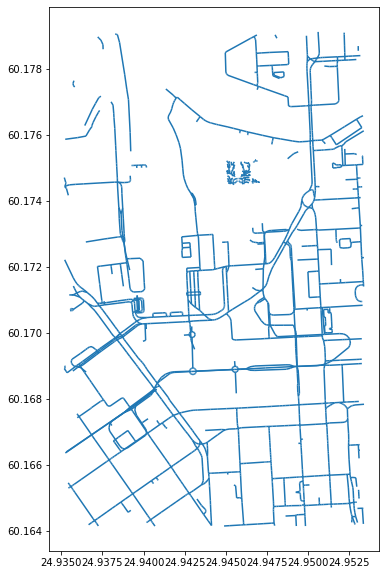

In [8]:
from pyrosm import OSM, get_data
import geopandas as gpd
import networkx as nx

# We will use test data for Helsinki that comes with pyrosm
osm = OSM(get_data("helsinki_pbf"))

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

In [7]:
roads.head(2)

,access,area,bicycle,bridge,cycleway,foot,footway,highway,int_ref,lanes,...,surface,tunnel,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,None,unclassified,None,2,...,paved,None,None,4236349,1380031970,21,"{""name:fi"":""Erottajankatu"",""name:sv"":""Skillnad...",way,"MULTILINESTRING ((24.94327 60.16651, 24.94337 ...",14.0
1,None,None,None,None,None,None,None,unclassified,None,2,...,paved,None,None,4243035,1543430213,12,"{""name:fi"":""Korkeavuorenkatu"",""name:sv"":""H\u00...",way,"MULTILINESTRING ((24.94567 60.16767, 24.94567 ...",51.0


Okay, now we have walkable roads as a GeoDataFrame for the city center of Helsinki. If you look at the GeoDataFrame (scroll to the right), we can see that `pyrosm` has also calculated us the `length` of each road segment (presented in meters). The geometries are presented here as `MultiLineString` objects. From the map above we can see that the data also includes short pieces of roads that do not lead to anywhere (i.e. they are *isolated*). This is a typical issue when working with real-world data such as roads. Hence, at some point we need to take care of those in someway (remove them (typical solution), or connect them to other parts of the network). 

In OSM, the information about the allowed direction of movement is stored in column `oneway`. Let's take a look what kind of values we have in that column:

In [9]:
roads["oneway"].unique()

array(['yes', None, 'no'], dtype=object)

As we can see the unique values in that column are `"yes"`, `"no"` or `None`. We can use this information to construct a `directed` graph for routing by car. For walking and cycling, you typically want create a `bidirectional` graph, because the travel is typically allowed in both directions at least in Finland. Notice, that the rules vary by country, e.g. in Copenhagen you have oneway rules also for bikes but typically each road have the possibility to travel both directions (you just need to change the side of the road if you want to make a U-turn). Column `maxspeed` contains information about the speed limit for given road:

In [24]:
roads["maxspeed"].unique()

array(['30', '40', None, '20', '10', '5', '50'], dtype=object)

As we can see, there are also `None` values in the data, meaning that the speed limit has not been tagged for some roads. This is typical, and often you need to fill the non existing speed limits yourself. This can be done by taking advantage of the road class that is always present in column `highway`:

In [26]:
roads["highway"].unique()

array(['unclassified', 'residential', 'secondary', 'service', 'tertiary',
       'primary', 'primary_link', 'cycleway', 'footway', 'tertiary_link',
       'pedestrian', 'trail', 'crossing'], dtype=object)

Based on these values, we can make assumptions that e.g. `residential` roads in Helsinki have a speed limit of 30 kmph. Hence, this information can be used to fill the missing values in `maxspeed`. 

Okay, but how can we make a routable graph out of this data of ours? Let's remind us about the basic elements of a graph that we went through in the lecture slides:

![Basic elements of a graph](img/graph_elements.png)

So to be able to create a graph we need to have **nodes** and **edges**. Now we have a GeoDataFrame of edges, but where are those nodes? Well they are not yet anywhere, but with `pyrosm` we can easily retrieve the nodes as well by specifying `nodes=True`, when parsing the streets:

(60.17, 60.173)

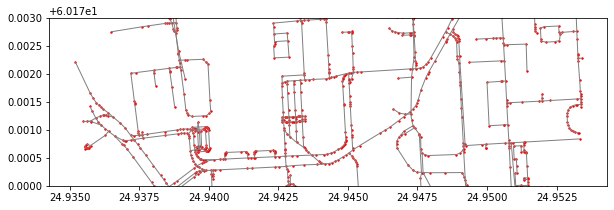

In [18]:
# Parse nodes and edges
nodes, edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = nodes.plot(ax=ax, color="red", markersize=2)

# Zoom in to take a closer look
#ax.set_xlim([24.9375, 24.945])
ax.set_ylim([60.17, 60.173])

Okay, as we can see now we have both the roads (i.e. *edges*) and the nodes that connect the street elements together (in red) that are typically intersections. However, we can see that many of the nodes are in locations that are clearly not intersections. This is intented behavior to ensure that we have full **connectivity** in our network. We can at later stage clean and simplify this network by merging all roads that belong to the same link (i.e. street elements that are between two intersections) which also reduces the size of the network. 

```{note} 

In OSM, the street topology is typically not directly suitable for graph traversal due to missing nodes at intersections which means that the roads are not splitted at those locations. The consequence of this, is that it is not possible to make a turn if there is no intersection present in the data structure. Hence, `pyrosm` will separate all road segments/geometries into individual rows in the data. 
```

Let's take a look what our nodes data look like:

In [19]:
nodes.head()

,lon,lat,tags,timestamp,version,changeset,id,geometry
0,24.943271,60.166514,None,1390926206,2,0,1372477605,POINT (24.94327 60.16651)
1,24.943365,60.166444,"{'highway': 'crossing', 'crossing': 'traffic_s...",1383915357,6,0,292727220,POINT (24.94337 60.16644)
2,24.943403,60.166408,None,1374595731,1,0,2394117042,POINT (24.94340 60.16641)
3,24.945668,60.167668,"{'highway': 'crossing', 'crossing': 'uncontrol...",1290714658,5,0,296250563,POINT (24.94567 60.16767)
4,24.945671,60.167630,{'traffic_calming': 'divider'},1354578076,1,0,2049084195,POINT (24.94567 60.16763)


As we can see, the `nodes` GeoDataFrame contains information about the coordinates of each node as well as a unique `id` for each node. These `id` values are used to determine the connectivity in our network. Hence, `pyrosm` has also added two columns to the `edges` GeoDataFrame that specify **from** and **to** ids for each edge. Column `u` contains information about the **from-id** and column `v` about the **to-id** accordingly:

In [23]:
# Check last five columns
edges.iloc[:5,-5:]

,osm_type,geometry,u,v,length
0,way,"LINESTRING (24.94327 60.16651, 24.94337 60.16644)",1372477605,292727220,9.370
1,way,"LINESTRING (24.94337 60.16644, 24.94340 60.16641)",292727220,2394117042,4.499
2,way,"LINESTRING (24.94567 60.16767, 24.94567 60.16763)",296250563,2049084195,4.174
3,way,"LINESTRING (24.94567 60.16763, 24.94569 60.16744)",2049084195,60072359,21.692
4,way,"LINESTRING (24.94569 60.16744, 24.94571 60.16726)",60072359,6100704327,19.083


We can see that the geometries are now stored as `LineString` instead of `MultiLineString`. `osm_type` columns provides information about which kind of OSM element the row is (possible values are `way`, `node`, `relation`). 

## 2. Modify the data

At this stage

In [4]:
# First rows of the edges
edges.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,service,tunnel,access,bridge,junction,ref
0,3216400385,301360890,0,15240373,Kansakoulukuja,residential,30,False,13.177,"LINESTRING (24.93400 60.16755, 24.93393 60.167...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1372233731,298367080,0,86533507,NaN,footway,NaN,False,6.925,"LINESTRING (24.92927 60.16229, 24.92917 60.16225)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1372233731,292859610,0,15103120,NaN,primary_link,30,False,33.874,"LINESTRING (24.92927 60.16229, 24.92930 60.162...",2,NaN,NaN,NaN,NaN,NaN,NaN
3,1372233731,2390968896,0,"[86533504, 23025219]",Hietalahdenkatu,primary,30,False,68.200,"LINESTRING (24.92927 60.16229, 24.92868 60.162...","[2, 3]",NaN,NaN,NaN,NaN,NaN,NaN
4,1372233731,4430643601,0,"[154412960, 86533507]",NaN,footway,NaN,False,12.489,"LINESTRING (24.92927 60.16229, 24.92941 60.162...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see from this edge-table, we have a lot of information. For routing purposes, the most useful attributes are `length` (in meters) and `maxspeed` (for car routing) which we can use to calculate travel times.

## 2. Modify the graph

Let's next modify the data in our graph, so that we can conduct the shortest path search based on travel time. 

In this case, we specify that the **walking speed is a static 4.5 kmph** and **cycling speed is 19 kmph**. We will calculate the cost of travel (time) for each road segment (i.e. edge) into a new column `walk_t` that we can later use as a weight variable in routing (also known as impedance or cost).  

In [5]:
# Calculate the time (in seconds) it takes to walk through road segments
walk_speed = 4.5  # kmph
edges['walk_t'] = (( edges['length'] / (walk_speed*1000) ) * 60 * 60).round(1)

# Do the same for cycling
cycling_speed = 19  # kmph
edges['bike_t'] = (( edges['length'] / (cycling_speed*1000) ) * 60 * 60).round(1)

# Let's check what we got
edges[['length', 'walk_t', 'bike_t']].head()

,length,walk_t,bike_t
0,13.177,10.5,2.5
1,6.925,5.5,1.3
2,33.874,27.1,6.4
3,68.200,54.6,12.9
4,12.489,10.0,2.4


## 3. Build graph

Now as we have calculated the travel time for our edges. We still need to convert our nodes and edges back to a NetworkX graph, so that we can start using it for routing. When using OSM data fetched with OSMnx this can be done easily with function `ox.gdfs_to_graph()`. Notice that this **only works when using OSMnx library**, we will later see in detail how the graphs are built from scratch which enables you to customize them.

- Let's build the graph with OSMnx:

In [6]:
G = ox.gdfs_to_graph(gdf_nodes=nodes, gdf_edges=edges)
type(G)

networkx.classes.multidigraph.MultiDiGraph

Okay, now we have converted our data back into a NetworkX graph. Let's ensure that our new edge attribute really exists:

In [7]:
# Check only the first row from edges
for fr, to, edge in G.edges(data=True):
    print(edge)
    break

{'osmid': 15240373, 'name': 'Kansakoulukuja', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'length': 13.177, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f4cd9bd0790>, 'walk_t': 10.5, 'bike_t': 2.5}


Great, as we can see now we have a new edge attribute in our graph that we can use for routing. 

## 4. Routing with NetworkX

Now we have everything we need to start routing with NetworkX (by walking and cycling). But first, let's again go through some basics about routing.

### Basic logic in routing

Most (if not all) routing algorithms work more or less in a similar manner. The basic steps for finding an optimal route from A to B, is to:
 1. Find the nearest node for origin location \* (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location \* (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them (can be distance, time, CO2, or whatever)
 
\* in more advanced implementations you might search for the closest edge

This same logic should be applied always when searching for an optimal route between a single origin to a single destination, or when calculating one-to-many -type of routing queries (producing e.g. travel time matrices). 

## Find the optimal route between two locations

Next, we will learn how to find the shortest path between two locations using [Dijkstra's](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) algorithm.

First, let's find the closest nodes for two locations that are located in the area. OSMnx provides a handly function for geocoding an address `ox.geocode()`. We can use that to retrieve the x and y coordinates of our origin and destination.

In [8]:
# OSM data is in WGS84 so typically we need to use lat/lon coordinates when searching for the closest node

# Origin
orig_address = "Kalevankatu 16, Helsinki"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Ruoholahdenkatu 24, Helsinki"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: 24.936245 60.1665678
Destination coords: 24.9246625 60.1641351


Okay, now we have coordinates for our origin and destination.

### Find the nearest nodes

Next, we need to find the closest nodes from the graph for both of our locations. For calculating the closest point we use here `'haversine'` formula to get the distance in meters (with `return_dist=True`).

In [9]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.get_nearest_node(G, point=(orig_y, orig_x), method='haversine', return_dist=True)
dest_node_id, dist_to_dest = ox.get_nearest_node(G, point=(dest_y, dest_x), method='haversine', return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 298372995 and distance: 43.872491349361404 meters.
Destination node-id: 5809140035 and distance: 48.867235001413256 meters.


Now we are ready to start the actual routing with NetworkX. 

### Find the fastest route by walking / cycling

Now we can do the routing and find the shortest path between the origin and target locations
by using the `dijkstra_path()` function of NetworkX. For getting only the cumulative cost of the trip, we can directly use a function `dijkstra_path_length()` that returns the travel time without the actual path. 

With `weight` -parameter we can specify the attribute that we want to use as cost/impedance. We have now three possible weight attributes available: `'length'`, `'walk_t'` and `'bike_t'`.    

- Let's first calculate the routes between locations by walking and cycling, and also retrieve the travel times

In [10]:
import networkx as nx
# Calculate the paths by walking and cycling
walk_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

# Get also the actual travel times (summarize)
walk_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='walk_t')
bike_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='bike_t')

719.8000000000002

Okay, that was it! Let's now see what we got as results by visualizing the results.

For visualization purposes, we can use a handy function again from OSMnx called `ox.plot_graph_route()` (for static) or `ox.plot_route_folium()` (for interactive plot).

- Let's first make static maps

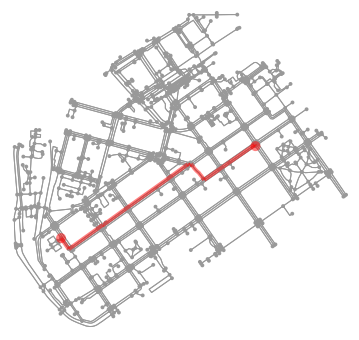

Text(0.5, 0, 'Walk time  12.0 minutes.')

In [13]:
# Walking
fig, ax = ox.plot_graph_route(G, walk_path)

# Add the travel time as title
ax.set_xlabel("Walk time {t: .1f} minutes.".format(t=walk_t/60))

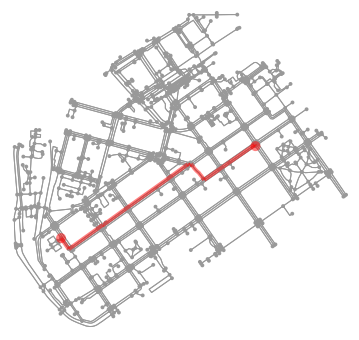

Text(0.5, 0, 'Cycling time  2.8 minutes.')

In [13]:
# Cycling
fig, ax = ox.plot_graph_route(G, bike_path)

# Add the travel time as title
ax.set_xlabel("Cycling time {t: .1f} minutes.".format(t=bike_t/60))

Great! Now we have successfully found the optimal route between our origin and destination and we also have estimates about the travel time that it takes to travel between the locations by walking and cycling. As we can see, the route for both travel modes is exactly the same which is natural, as the only thing that changed here was the constant travel speed.

- Let's still finally see an example how you can plot a nice interactive map out of our results with OSMnx:

In [14]:
ox.plot_route_folium(G, walk_path, popup_attribute='walk_t')

## Calculate travel times from one to many locations

When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many) or use isochrones (travel time contours). 

- Let's see how we can calculate travel times from the origin node, to all other nodes in our graph using NetworkX function `single_source_dijkstra_path_length()`:

In [17]:
# Calculate walk travel times originating from one location
walk_times = nx.single_source_dijkstra_path_length(G, source=orig_node_id, weight='walk_t')

# What did we get?
#walk_times

In [18]:
walk_times

{298372995: 0,
 310042886: 4.3,
 298372997: 4.8,
 1377211668: 9.1,
 298372992: 10.1,
 298372994: 10.5,
 298372999: 14.6,
 298373001: 15.0,
 298275980: 20.4,
 1008235033: 58.6,
 298275990: 61.6,
 298275993: 63.1,
 298137948: 64.5,
 1008235101: 68.4,
 1371750095: 68.5,
 298137946: 69.6,
 298275982: 71.10000000000001,
 298372996: 72.7,
 298278778: 74.1,
 298275983: 74.7,
 299968946: 77.3,
 299968465: 77.8,
 298275987: 79.69999999999999,
 5047535963: 80.8,
 1377211666: 82.6,
 299968473: 82.7,
 299968467: 83.2,
 299968469: 87.4,
 299968471: 87.7,
 3227176324: 89.9,
 298275409: 92.9,
 3227176325: 94.3,
 6339939821: 96.39999999999999,
 5047535961: 103.19999999999999,
 3227176316: 104.5,
 166048146: 108.2,
 298372990: 115.7,
 299968475: 116.7,
 6339939825: 119.6,
 298372991: 120.0,
 5307121092: 120.60000000000001,
 298372989: 120.7,
 1377208998: 121.3,
 60170471: 124.7,
 311747895: 124.89999999999999,
 298372077: 125.3,
 298372986: 125.3,
 434153002: 125.89999999999999,
 3216400418: 126.6,
 29

As we can see, the result is a dictionary where we have the **node_id** as keys and the **travel time** as values. 

For visualizing this information, we need to join this data with the nodes. For doing this, we can first convert the result to DataFrame and then we can easily merge the information with the nodes GeoDataFrame.

In [19]:
import pandas as pd
# Convert to DataFrame and add column names
walk_times_df = pd.DataFrame([list(walk_times.keys()), list(walk_times.values())]).T
walk_times_df.columns = ['node_id', 'walk_t']

# What do we have now?
walk_times_df.head()

,node_id,walk_t
0,2.983730e+08,0.0
1,3.100429e+08,4.3
2,2.983730e+08,4.8
3,1.377212e+09,9.1
4,2.983730e+08,10.1


Great! Now we have the travel times **from origin** to all other nodes in the graph. 

- Let's finally merge the data with the nodes GeoDataFrame and visualize the results

In [20]:
# Check the nodes
nodes.head()

,y,x,osmid,highway,ref,geometry
3216400385,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755)
1372233731,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229)
1005744134,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162)
319885318,60.165072,24.925487,319885318,NaN,NaN,POINT (24.92549 60.16507)
3216400394,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766)


As we can see, the `node_id` in the nodes GeoDataFrame can be found from the `index` of the gdf as well as from the column `osmid`. 

- Let's merge these two datasets:

In [21]:
# Merge the datasets
nodes = nodes.merge(walk_times_df, left_on='osmid', right_on='node_id')

# Check
nodes.head()

,y,x,osmid,highway,ref,geometry,node_id,walk_t
0,60.167552,24.934005,3216400385,turning_circle,NaN,POINT (24.93400 60.16755),3.216400e+09,208.4
1,60.162290,24.929274,1372233731,crossing,NaN,POINT (24.92927 60.16229),1.372234e+09,639.3
2,60.161622,24.924423,1005744134,NaN,NaN,POINT (24.92442 60.16162),1.005744e+09,775.7
3,60.165072,24.925487,319885318,NaN,NaN,POINT (24.92549 60.16507),3.198853e+08,616.9
4,60.167662,24.933920,3216400394,NaN,NaN,POINT (24.93392 60.16766),3.216400e+09,193.6


Okay, now we have also the travel times associated for each node. 

- Let's visualize this:

(60.16, 60.17)

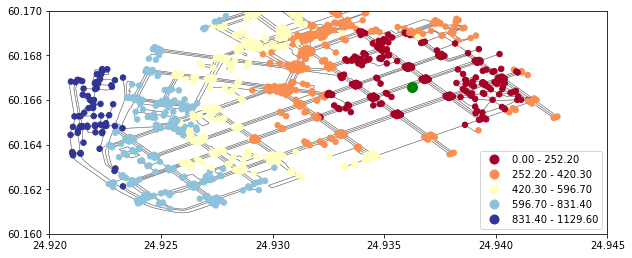

In [23]:
%matplotlib inline

# Make a GeoDataFrame for the origin point so that we can visualize it
orig = gpd.GeoDataFrame({'geometry': [Point(orig_x, orig_y)]}, index=[0], crs={'init': 'epsg:4326'})

# Plot the results with edges and the origin point (green)
ax = edges.plot(lw=0.5, color='gray', zorder=0, figsize=(10,10))
ax = nodes.plot('walk_t', ax=ax, cmap='RdYlBu', scheme='natural_breaks', k=5, markersize=30, legend=True)
ax = orig.plot(ax=ax, markersize=100, color='green')

# Adjust axis 
ax.set_xlim([24.92, 24.945])
ax.set_ylim([60.160, 60.170])

Okay, as we can see now we have quickly calculated the travel times for each node in the graph using a single call.

If you would have for example a predefined grid, you could find the nearest node for each grid centroid to produce a more matrix-like result. 

### Alternative approach - Ego graph

Alternatively, it is possible to directly set a specific time limit and restrict **how long the graph is travelled** from the origin, and return that subgraph for the user. 

- Let's see an example:

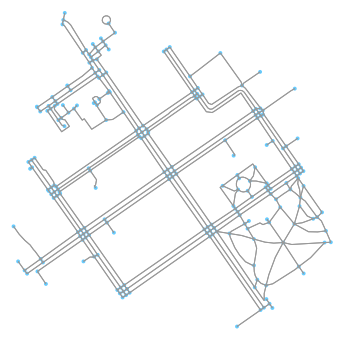

In [24]:
# Take a subgraph until 4 minutes by walking (240 seconds)
subgraph = nx.ego_graph(G, n=orig_node_id, radius=240, distance='walk_t')
fig, ax = ox.plot_graph(subgraph)

As we can see, with this approach we can retrieve a partial graph that we could for example visualize with different colors, or e.g. subset the extent of our accessibility analysis to cover only specific range from the source. 